In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

---------------------------

# Python Programming for Ocean Management: Real-time mapping of the fishing footprint in Atlantic Canada



Python Tutorial for Internation Ocean Institute (class 2018)

---------------------------

A rendered version of this workshop: https://github.com/Diego-Ibarra/workshop_IOI_2018/blob/master/workshop_2018.ipynb

The repository for this workshop is https://github.com/Diego-Ibarra/workshop_IOI_2018 and contains:

- the workshop's jupyter notebook
- data
- shapefiles
- other polygons

-------------------------------




## Case study: Real-time mapping of the fishing footprint in support of North Atlantic Right Whale conservation

---------------------------

<center>North Atlantic Right Whale (*Eubalaena glacialis*) - Only ~400 individuals left!</center>

![alt text](images/rightwhalewdiver.jpg)

-----------------------

<center> Entaglement with fishing gear is one of the causes of mortality </center>

![alt text](images/180201-eac-va-right-whale-entangled-sea-to-shore.jpg)

------------------------------

# VMS (Vessel Monitoring System)

Satellite trasnponder than many fishing vessels are required to carry.

![alt text](images/0000018_romtrax-wi-fi-vms_550.jpeg)

![alt text](images/vessel-monitoring-aid-kkp.jpg)



------------------
# Whale sightings

Take a look to `whale_sightings.csv`

In [2]:
import pandas as pd

whales = pd.read_csv('data/whale_sightings.csv')

In [3]:
whales

Date  Latitude  Longitude  Number of right whales
0  31/05/2018  47.59990 -64.098750                       1
1  27/05/2018  48.15185 -63.381437                       1
2  24/05/2018  44.58650 -63.058000                       1
3  24/05/2018  44.63517 -62.678800                       1
4  03/05/2018  42.83000 -65.150000                       1


------------------
### Very basic "mapping" of whale data (non projected) 


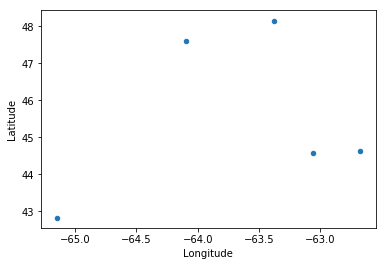

In [4]:
whales.plot(x='Longitude',y='Latitude',kind='scatter')

------------------
### "Projected" mapping of whale data: Adding land


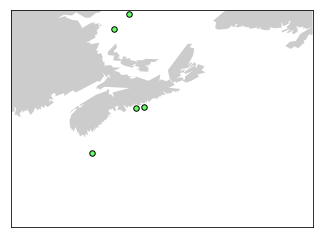

In [5]:
from mpl_toolkits.basemap import Basemap

# Create basemap object
m = Basemap(projection='mill',
            llcrnrlat=39.9,
            urcrnrlat=48.3,
            llcrnrlon=-69,
            urcrnrlon=-54.7,
            resolution='l')

# Convert lats/lons into projected x/y coordinates
x, y = m(whales['Longitude'].values,whales['Latitude'].values)

cs = m.scatter(x,y,s=30,marker='o',color='#66ff66', edgecolor='k')

m.fillcontinents()

### Packaging the mapping code into "Functions" for easy reuse

In [6]:
def make_basemap():    
    from mpl_toolkits.basemap import Basemap

    # Create basemap object
    m = Basemap(projection='mill',
                llcrnrlat=39.9,
                urcrnrlat=48.3,
                llcrnrlon=-69,
                urcrnrlon=-54.7,
                resolution='l')
    
    m.fillcontinents()
    return m



def plot_whales(whales, m):
    # Convert lats/lons into projected x/y coordinates
    x, y = m(whales['Longitude'].values,whales['Latitude'].values)

    cs = m.scatter(x,y,s=60,marker='o',color='#66ff66', edgecolor='k',zorder=50)
    return

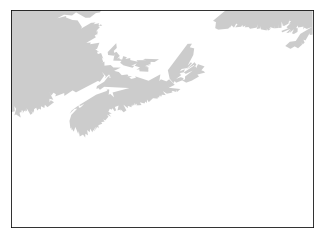

In [7]:
make_basemap()

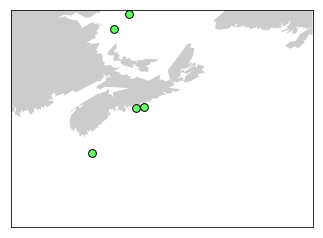

In [8]:
make_basemap()
plot_whales(whales, m)

### Tweaking our "Function" to make a nicer basemap

In [9]:
def make_basemap():
    import matplotlib.pyplot as plt
    from mpl_toolkits.basemap import Basemap
    
    fig1 = plt.figure(figsize=(13,10))

    # Create basemap object
    m = Basemap(projection='mill',
                llcrnrlat=39.9,
                urcrnrlat=48.3,
                llcrnrlon=-69,
                urcrnrlon=-54.7,
                resolution='i')
    
    m.drawcoastlines(color='#a6a6a6',linewidth=0.5,zorder=42)
    m.fillcontinents(color='#e6e6e6',zorder=42)
    m.drawmapboundary()
    plt.tight_layout() # Elimite white space around figure
    return m

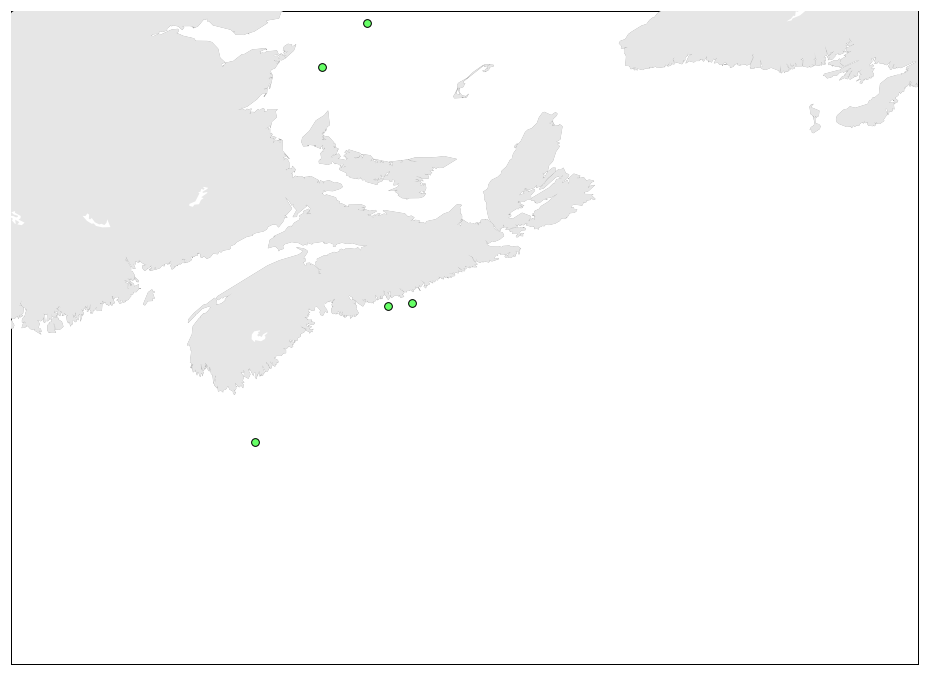

In [10]:
m = make_basemap()
plot_whales(whales, m)

### Interactive plotting

<IPython.core.display.Javascript object>


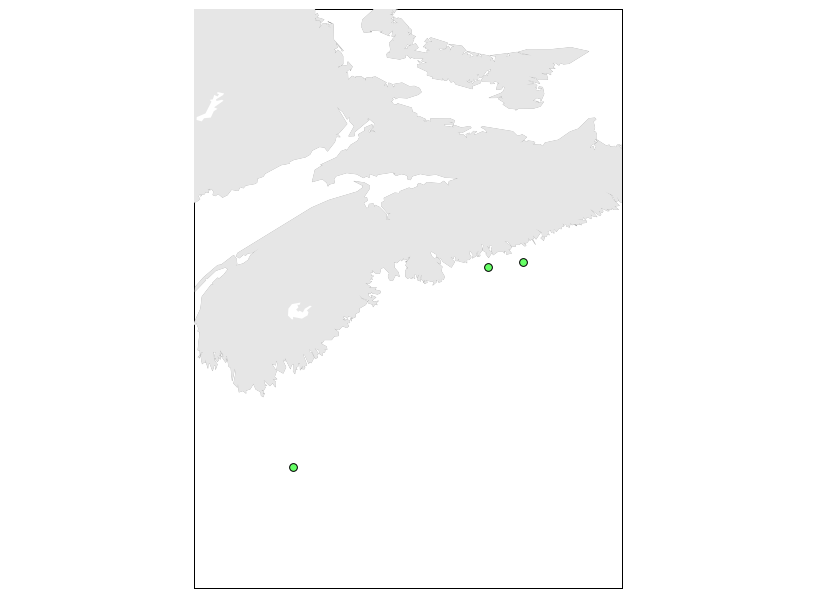

In [27]:
%matplotlib notebook
m = make_basemap()
plot_whales(whales, m)

----------------------
## Importing functions from an external file (i.e. `my_fucntions.py`):

### Adding the "Maritimes Region" polygon

<IPython.core.display.Javascript object>


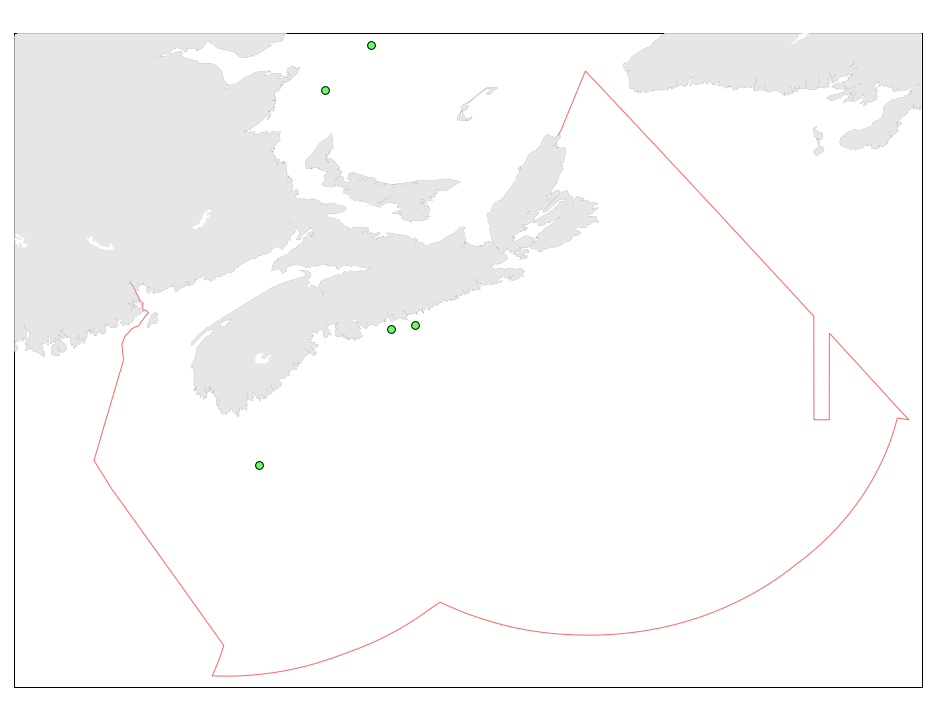

In [28]:
import my_functions as mf

m = make_basemap()
plot_whales(whales, m)
mf.add_maritimes_region(m)

----------------------

### Adding "Critical Habitat" polygons

<IPython.core.display.Javascript object>


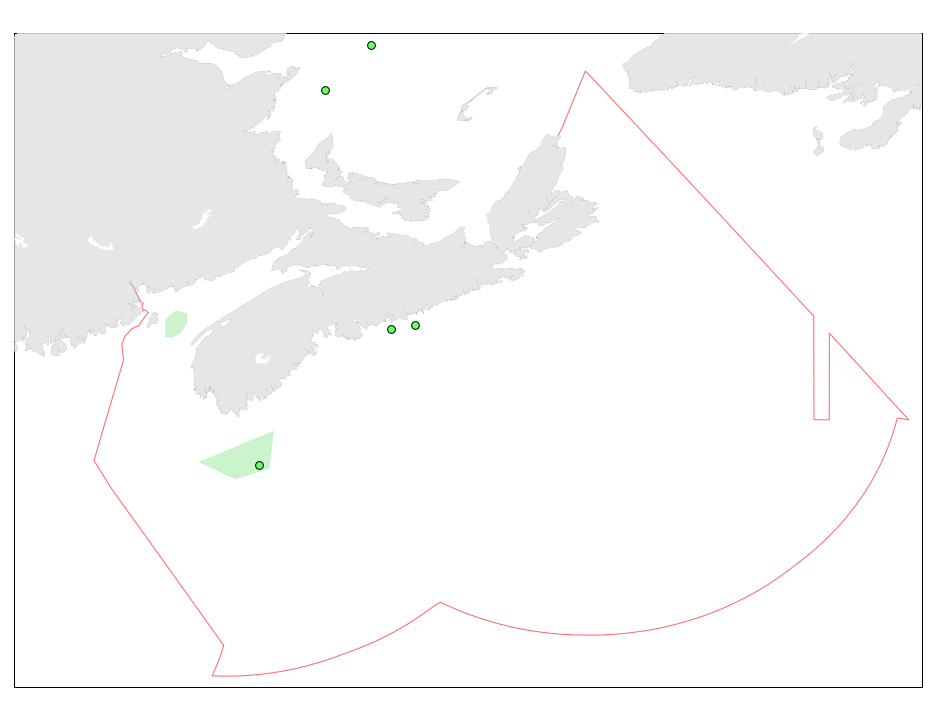

In [29]:
import my_functions as mf

m = make_basemap()
plot_whales(whales, m)
mf.add_maritimes_region(m)
mf.plot_CriticalHabitats(m)

----------------------

### Adding the "NAFO subregions" polygons

<IPython.core.display.Javascript object>


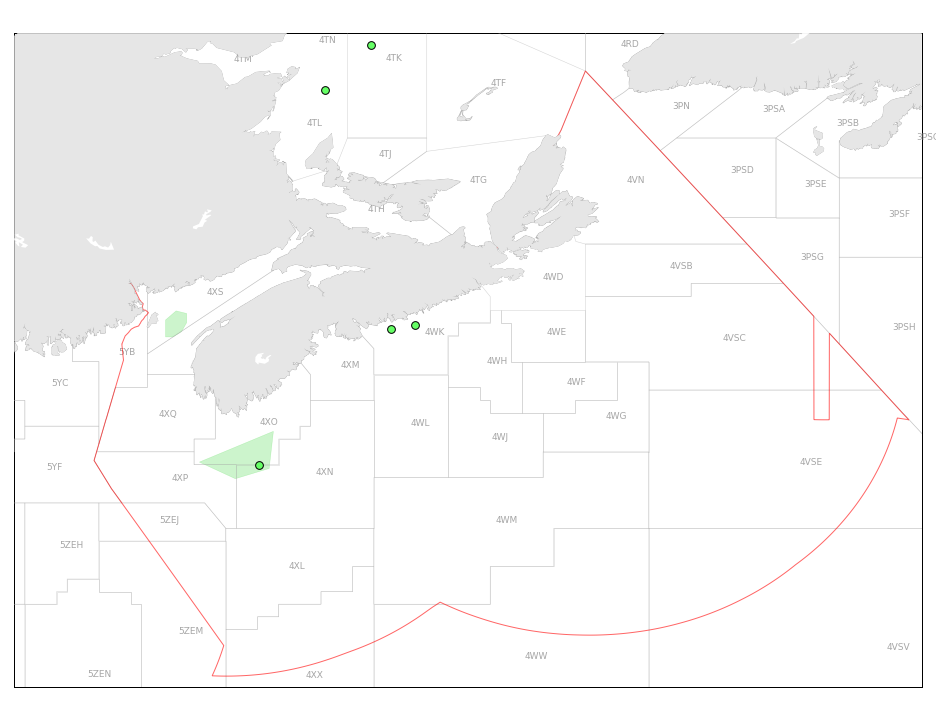

In [30]:
m = make_basemap()
plot_whales(whales,m)
mf.add_maritimes_region(m)
mf.add_NAFO_areas(m)
mf.plot_CriticalHabitats(m)

----------------------

### Make a function to download bathymetry (from ERDDAP server) 


In [31]:
def add_bathymetry(m):
    '''
    Download bathymetry data from NOAA's ERDDAP server, and ads it to basemap
    '''
    import matplotlib.pyplot as plt
    import netCDF4
    import urllib.request
    import numpy as np
    
    bathymetry_file = 'usgsCeSrtm30v6.nc'

    minlat=39.9
    maxlat=48.3
    minlon=-69
    maxlon=-54.7
    
    isub = 1
    base_url='http://coastwatch.pfeg.noaa.gov/erddap/griddap/usgsCeSrtm30v6.nc?'
    query='topo[(%f):%d:(%f)][(%f):%d:(%f)]' % (maxlat,isub,minlat,minlon,isub,maxlon)
    url = base_url+query
    # store data in NetCDF file
    urllib.request.urlretrieve(url, bathymetry_file)

    # open NetCDF data in
    nc = netCDF4.Dataset(bathymetry_file)
    ncv = nc.variables
    lon = ncv['longitude'][:]
    lat = ncv['latitude'][:]
    lons, lats = np.meshgrid(lon, lat)
    topo = ncv['topo'][:, :]
    
    # Mask everything above ground
    TOPOmasked = np.ma.masked_where(topo>0,topo)

    # For topo
    x, y = m(lons, lats)
    plt.pcolormesh(x,y,TOPOmasked,cmap=plt.get_cmap('Blues_r'),zorder=5,vmax=2000)

    # Countoured isolines
    depth_levels_1 = np.linspace(topo.min(), -700, num=5)

    depth_levels = np.append(depth_levels_1,np.linspace(-650, -50, num=15))

    depth_levels = depth_levels.tolist()

    cs = plt.contour(
        x,
        y,
        topo,
        depth_levels,
        cmap=plt.get_cmap('Blues_r'),
        linewidths=0.3,
        linestyles='solid',
        zorder=19)
    return

Lets use our new `add_bathmetry` function

<IPython.core.display.Javascript object>


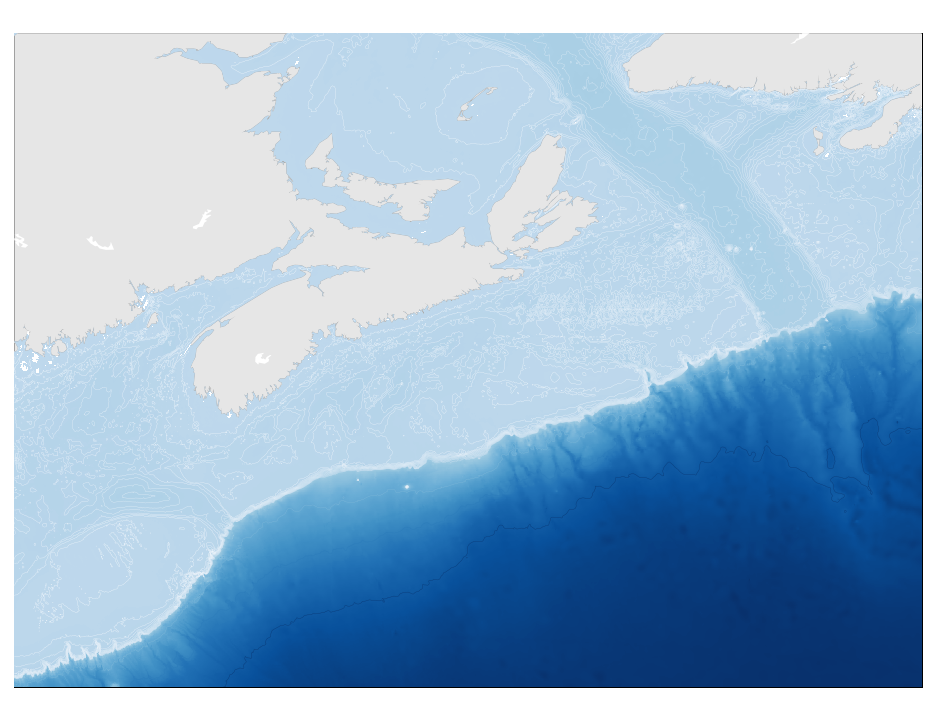

In [32]:
m = make_basemap()
add_bathymetry(m)

---------------

## Make basemap and "pickle" it for WAY FASTER display in future plots 


<IPython.core.display.Javascript object>


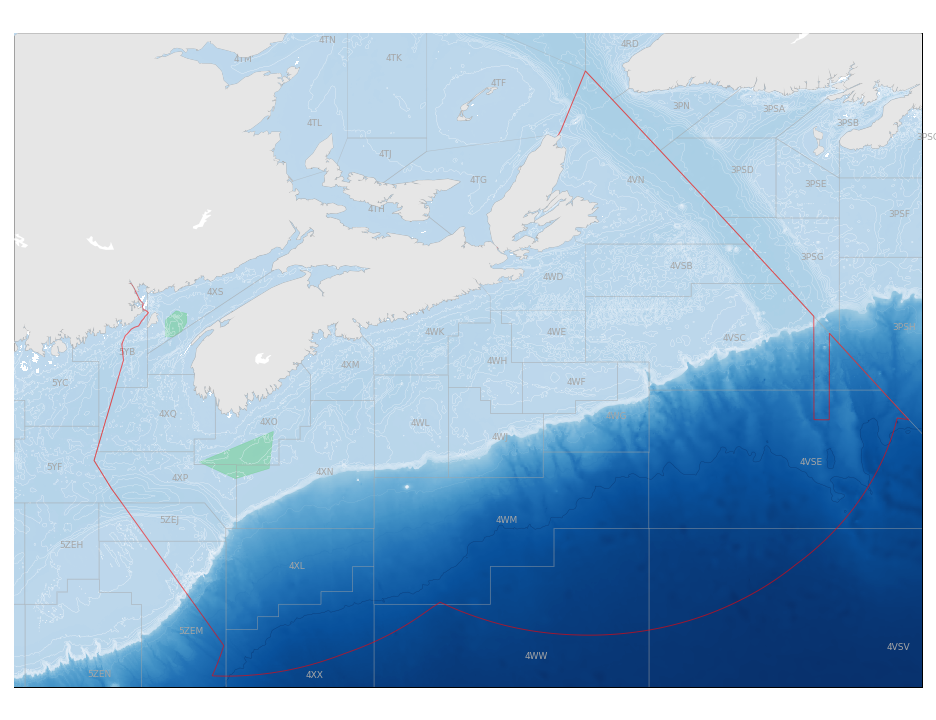

In [33]:
import _pickle as pickle

m = make_basemap()

mf.add_maritimes_region(m)
mf.add_NAFO_areas(m)
mf.plot_CriticalHabitats(m)
add_bathymetry(m)

# Save m to pickle
pickle.dump(m, open('basemap.p', 'wb'), -1)

--------------

### Test our new "fast-loading" pickled basemap

<IPython.core.display.Javascript object>


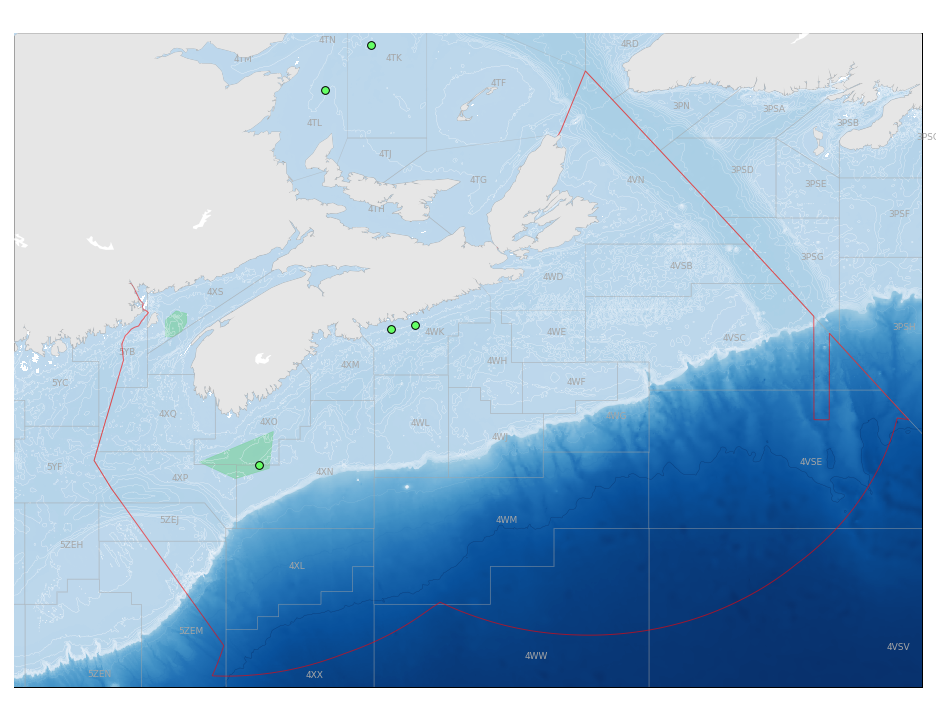

In [34]:
# "Unpickle" m
m = pickle.load(open('basemap.p','rb'))

plot_whales(whales,m)


------------------
# Fishing footprint (VMS)

![alt text](images/Longline-3.jpg)


In [35]:
vms_csv = 'data/vms_autoDownloaded.csv'

fishing_ships = pd.read_csv(vms_csv)

In [36]:
fishing_ships

VR_NUMBER   LATITUDE  LONGITUDE    POSITION_UTC_DATE
0         105736  41.920140 -66.806320  2018-05-30 06:00:01
1         106604  42.083890 -66.738820  2018-05-30 06:00:01
2         107314  42.226200 -66.135190  2018-05-30 06:00:01
3         106881  42.708690 -66.074310  2018-05-30 06:00:01
4         106658  42.887363 -67.486954  2018-05-30 06:00:01
5           4062  43.541360 -60.516110  2018-05-30 06:00:01
6         103210  43.554300 -64.054420  2018-05-30 06:00:01
7         104984  43.617040 -65.786250  2018-05-30 06:00:01
8         106311  43.617353 -65.786391  2018-05-30 06:00:01
9         108193  43.724555 -65.841237  2018-05-30 06:00:01
10        105912  44.062470 -64.387010  2018-05-30 06:00:01
11        104994  44.199886 -63.259192  2018-05-30 06:00:01
12        108007  44.397420 -66.206110  2018-05-30 06:00:01
13        102339  44.421844 -60.078307  2018-05-30 06:00:01
14        100247  44.477891 -63.600112  2018-05-30 06:00:01
15        100009  44.480200 -63.578010  2018-05-30 06:00:01
16         20010  44.656620 -63.946100  2018-05-30 06:00:01
17        106404  44.661880 -66.756110  2018-05-30 06:00:01
18        100967  44.729289 -63.008567  2018-05-30 06:00:01
19        101593  44.884070 -65.980820  2018-05-30 06:00:01
20        105716  44.943609 -66.920214  2018-05-30 06:00:01
21        108148  44.944209 -66.920043  2018-05-30 06:00:01
22        107202  44.949270 -65.265530  2018-05-30 06:00:01
23         18107  44.964620 -65.827960  2018-05-30 06:00:01
24        108177  45.032787 -65.689145  2018-05-30 06:00:01
25        108317  45.058193 -60.452271  2018-05-30 06:00:01
26        105877  45.231640 -65.191390  2018-05-30 06:00:01
27        105679  45.916843 -59.970761  2018-05-30 06:00:01
28        161024  45.920276 -59.959260  2018-05-30 06:00:01
29        160602  46.005849 -59.841071  2018-05-30 06:00:01
...          ...        ...        ...                  ...
60788     153378  47.051524 -62.634001  2018-06-06 05:40:00
60789      12258  48.166180 -64.371990  2018-06-06 05:40:05
60790     108129  44.192777 -66.165277  2018-06-06 05:40:27
60791     151824  46.917000 -55.391500  2018-06-06 05:41:00
60792     153378  47.051524 -62.634602  2018-06-06 05:45:00
60793     152924  48.257500 -62.008500  2018-06-06 05:45:00
60794     136392  48.258218 -62.008639  2018-06-06 05:45:00
60795     133060  45.161447 -55.176860  2018-06-06 05:45:01
60796      12258  48.171480 -64.363690  2018-06-06 05:45:05
60797     139941  48.279780 -62.021520  2018-06-06 05:45:36
60798      99354  46.456500 -56.869500  2018-06-06 05:46:00
60799     103094  46.636500 -61.010620  2018-06-06 05:46:01
60800     153378  47.051439 -62.635117  2018-06-06 05:50:00
60801      12258  48.176780 -64.355090  2018-06-06 05:50:05
60802     108129  44.192500 -66.165555  2018-06-06 05:50:45
60803      90438  45.000000 -65.000000  2018-06-06 05:52:00
60804     153378  47.051524 -62.635718  2018-06-06 05:55:00
60805      12258  48.181980 -64.346690  2018-06-06 05:55:05
60806     108129  44.192777 -66.165277  2018-06-06 05:55:47
60807     131668  43.831750 -66.125980  2018-06-06 06:00:00
60808     149795  45.904580 -56.811550  2018-06-06 06:00:00
60809     137936  46.360930 -56.895390  2018-06-06 06:00:00
60810       5585  46.370300 -55.157810  2018-06-06 06:00:00
60811       5666  46.480235 -57.004967  2018-06-06 06:00:00
60812      18079  46.943820 -55.538750  2018-06-06 06:00:00
60813     102861  47.031050 -55.173070  2018-06-06 06:00:00
60814     153378  47.051524 -62.636319  2018-06-06 06:00:00
60815      94141  47.479230 -59.014140  2018-06-06 06:00:00
60816     152924  48.258500 -62.009500  2018-06-06 06:00:00
60817     136392  48.260020 -62.009841  2018-06-06 06:00:00

[60818 rows x 4 columns]

------------------
### Open basemap, plot VMS fishing "pings"


<IPython.core.display.Javascript object>


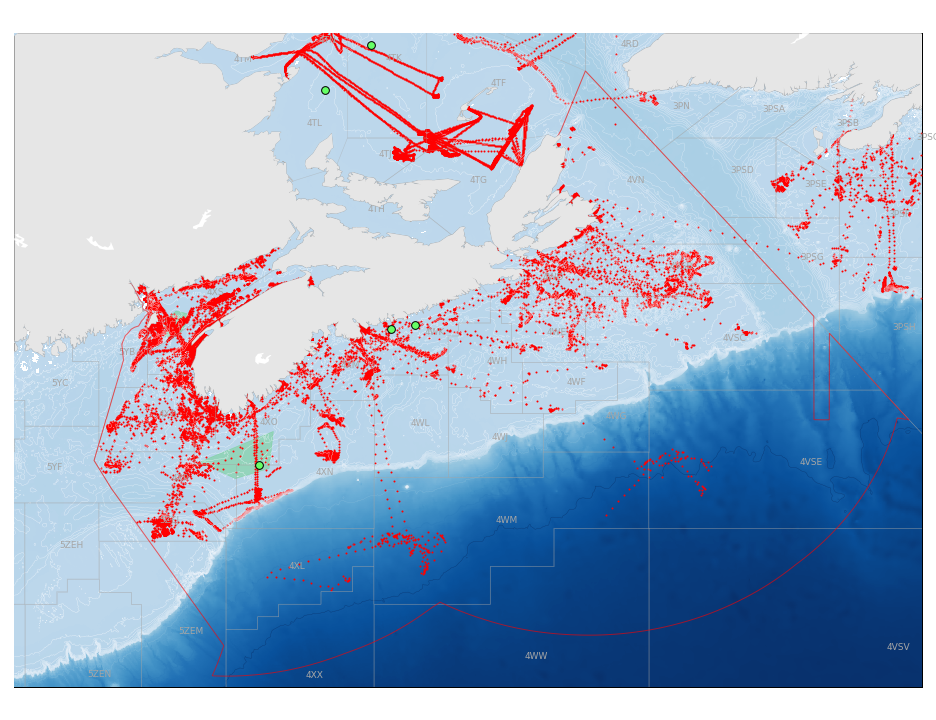

In [37]:
import matplotlib.pyplot as plt

m = pickle.load(open('basemap.p','rb'))

# Change Lat/Lons into proyected x/y coordinates
x, y = m(fishing_ships['LONGITUDE'].values,fishing_ships['LATITUDE'].values)

plt.scatter(x,y,s=1,marker='o',color='r', zorder=10)

plot_whales(whales,m)

In [38]:
def make_heatmap(info, m, data):
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt

    # Change Lat/Lons into proyected x/y coordinates
    x,y = m(data['LONGITUDE'].values, data['LATITUDE'].values)
    
    # Project x/y into grid. Count how many "pings" per grid
    H, xedges, yedges = np.histogram2d(x,y,bins=300)
    
    # Rotate and flip H... don't ask why this is needed :(
    H = np.rot90(H)
    H = np.flipud(H)
     
    # Mask zeros
    Hmasked = np.ma.masked_where(H==0,H)
     
    # Log H for better display
    Hmasked = np.log10(Hmasked)
     
    # Make map
    cs = m.pcolor(xedges,yedges,Hmasked,cmap=plt.get_cmap('inferno_r'), zorder=49)
    
    return

<IPython.core.display.Javascript object>


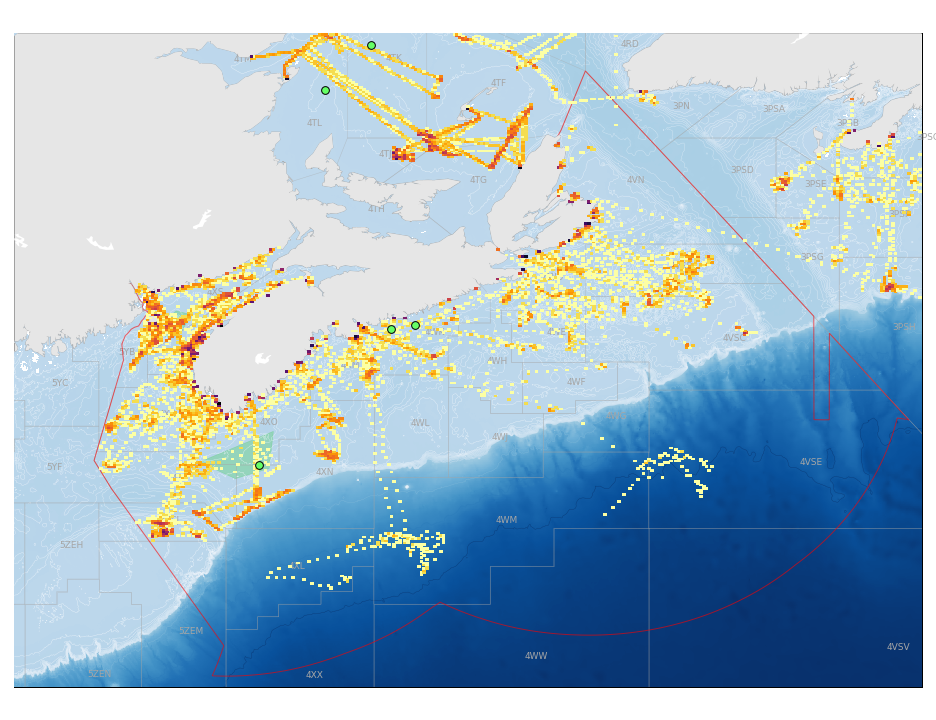

In [39]:
#Make info dictionary
info = {}
info['minlat'] = 39.9
info['maxlat'] = 48.3
info['minlon'] = -69
info['maxlon'] = -54.7
info['bin_size'] = 0.01 # Degrees

m = pickle.load(open('basemap.p','rb'))

plot_whales(whales,m)

make_heatmap(info, m, fishing_ships)


------------------
## Filter `fishing_ships` data by speed

Note that - when fishing - vessels usually travel between 0.5 and 4.5 knots

### First, we have to estimate "speed"

In [40]:
from datetime import datetime
import numpy as np
import my_functions as mf

# Make empty lists
VR_NUMBER, LATITUDE, LONGITUDE, POSITION_UTC_DATE, SPEED_KNOTS = [],[],[],[],[]

# Find unique ships
unis = pd.unique(fishing_ships['VR_NUMBER'])

for ship in unis:
    singleship = fishing_ships[fishing_ships['VR_NUMBER'] == ship].reset_index()
    
    if len(singleship) > 1:
    
        # Note that the first point of each ship is "ditched"
        for i in range(1,len(singleship)):

            startdate = datetime.strptime(singleship['POSITION_UTC_DATE'][i-1], '%Y-%m-%d %H:%M:%S')
            enddate = datetime.strptime(singleship['POSITION_UTC_DATE'][i], '%Y-%m-%d %H:%M:%S')

            elapsed_time = enddate-startdate
            elapsed_distance = mf.distance(singleship['LATITUDE'][i-1],
                                        singleship['LONGITUDE'][i-1],
                                        singleship['LATITUDE'][i],
                                        singleship['LONGITUDE'][i]) / 1852
            
            # Calculate speed
            if elapsed_time.seconds > 0:
                speed = elapsed_distance / (elapsed_time.seconds / 3600)
            else:
                speed = np.nan

            # Fill in lists 
            VR_NUMBER.append(singleship['VR_NUMBER'][i])
            LATITUDE.append(singleship['LATITUDE'][i])
            LONGITUDE.append(singleship['LONGITUDE'][i])
            POSITION_UTC_DATE.append(singleship['POSITION_UTC_DATE'][i])
            SPEED_KNOTS.append(speed)

# Place lists into new DataFrame
new_fishing_ships = pd.DataFrame({'VR_NUMBER':VR_NUMBER,
                        'LATITUDE':LATITUDE,
                        'LONGITUDE':LONGITUDE,
                        'POSITION_UTC_DATE':POSITION_UTC_DATE,
                        'SPEED_KNOTS':SPEED_KNOTS})
   

Note that `new_fishing_ships` has an extra column named `SPEED_KNOTS`

In [41]:
new_fishing_ships 

VR_NUMBER  LATITUDE  LONGITUDE    POSITION_UTC_DATE  SPEED_KNOTS
0         105736  41.91523  -66.80535  2018-05-30 07:00:00     0.298050
1         105736  41.91282  -66.79898  2018-05-30 08:00:00     0.319276
2         105736  41.92548  -66.79356  2018-05-30 09:00:01     0.797527
3         105736  41.90215  -66.80386  2018-05-30 10:00:00     1.474812
4         105736  41.88064  -66.74916  2018-05-30 11:00:00     2.764955
5         105736  41.95273  -66.82660  2018-05-30 12:00:00     5.541165
6         105736  41.96810  -66.80033  2018-05-30 13:00:01     1.491969
7         105736  41.93096  -66.81471  2018-05-30 14:00:01     2.320515
8         105736  41.90643  -66.80374  2018-05-30 15:00:00     1.552626
9         105736  41.91686  -66.80647  2018-05-30 16:00:00     0.637991
10        105736  41.92436  -66.78886  2018-05-30 17:00:01     0.906222
11        105736  41.92513  -66.80194  2018-05-30 18:00:00     0.586292
12        105736  41.91211  -66.80714  2018-05-30 19:00:00     0.815516
13        105736  41.92445  -66.79958  2018-05-30 20:00:01     0.814026
14        105736  41.90412  -66.80102  2018-05-30 21:00:01     1.222317
15        105736  41.90073  -66.81340  2018-05-30 22:00:01     0.589480
16        105736  41.89960  -66.81016  2018-05-30 23:00:00     0.159943
17        105736  41.90070  -66.81896  2018-05-31 00:00:00     0.398768
18        105736  41.90408  -66.83666  2018-05-31 01:00:01     0.816354
19        105736  41.91555  -66.80489  2018-05-31 02:00:00     1.578211
20        105736  41.91418  -66.79516  2018-05-31 03:00:00     0.442434
21        105736  41.91031  -66.80645  2018-05-31 04:00:01     0.555228
22        105736  41.91339  -66.79768  2018-05-31 05:00:00     0.433412
23        105736  41.92890  -66.79825  2018-05-31 06:00:01     0.931317
24        105736  41.91385  -66.79272  2018-05-31 07:00:00     0.937032
25        105736  41.90136  -66.80840  2018-05-31 08:00:00     1.026280
26        105736  41.92021  -66.79906  2018-05-31 09:00:01     1.205918
27        105736  41.89005  -66.79980  2018-05-31 10:00:00     1.811625
28        105736  41.92120  -66.79980  2018-05-31 11:00:00     1.870260
29        105736  41.90959  -66.82385  2018-05-31 12:00:01     1.280453
...          ...       ...        ...                  ...          ...
60354     152924  48.15850  -61.50850  2018-06-05 22:45:00     8.654773
60355     152924  48.18850  -61.54250  2018-06-05 23:00:00     9.031178
60356     152924  48.21900  -61.57550  2018-06-05 23:14:00     9.675858
60357     152924  48.24500  -61.61650  2018-06-05 23:30:00     8.489973
60358     152924  48.25550  -61.66850  2018-06-05 23:45:00     8.689702
60359     152924  48.25600  -61.72850  2018-06-06 00:00:00     9.594834
60360     152924  48.24500  -61.78050  2018-06-06 00:15:00     8.725267
60361     152924  48.22750  -61.82650  2018-06-06 00:30:00     8.473954
60362     152924  48.22200  -61.86950  2018-06-06 00:45:00     7.005580
60363     152924  48.21950  -61.91100  2018-06-06 00:59:00     7.143789
60364     152924  48.22750  -61.95600  2018-06-06 01:14:00     7.452034
60365     152924  48.26150  -61.97350  2018-06-06 01:30:00     8.092380
60366     152924  48.27400  -62.00150  2018-06-06 01:45:00     5.389656
60367     152924  48.28400  -62.01350  2018-06-06 02:00:00     3.073480
60368     152924  48.28000  -61.97250  2018-06-06 02:15:00     6.622634
60369     152924  48.25550  -61.98300  2018-06-06 02:30:00     6.118712
60370     152924  48.26450  -62.01850  2018-06-06 02:45:00     6.073646
60371     152924  48.24450  -61.99450  2018-06-06 03:00:00     6.148108
60372     152924  48.22550  -61.94950  2018-06-06 03:15:00     8.522898
60373     152924  48.21900  -61.89250  2018-06-06 03:29:00     9.913907
60374     152924  48.21200  -61.83050  2018-06-06 03:44:00    10.063105
60375     152924  48.20550  -61.77000  2018-06-06 04:00:00     9.194953
60376     152924  48.19850  -61.70800  2018-06-06 04:15:00    10.065684
60377     152924  48.21350  -61.75950  2018-06-

<IPython.core.display.Javascript object>


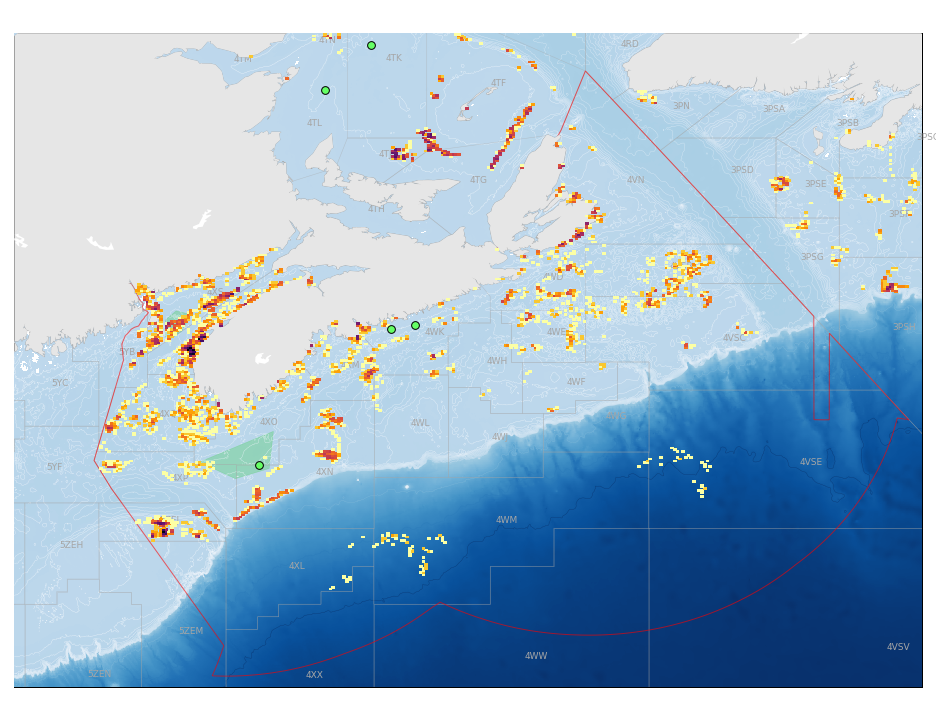

In [42]:
myFilter = (new_fishing_ships['SPEED_KNOTS']>0.5) & (new_fishing_ships['SPEED_KNOTS']<4.5)

filtered_fishing_ships = new_fishing_ships[myFilter]

m = pickle.load(open('basemap.p','rb'))

plot_whales(whales,m)

make_heatmap(info, m, filtered_fishing_ships)